In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [4]:
#read in the data
diagnosis_df = pd.read_excel('~/ird_dataset/IRD-Dataset-Complete-03-anonymized.xlsx')
diagnosis_df.head()

,Diagnose,CFP,Index
0,Morbus Stargardt,True,1
1,Morbus Stargardt,True,2
2,Morbus Stargardt,True,3
3,PXE,True,4
4,PXE,False,5


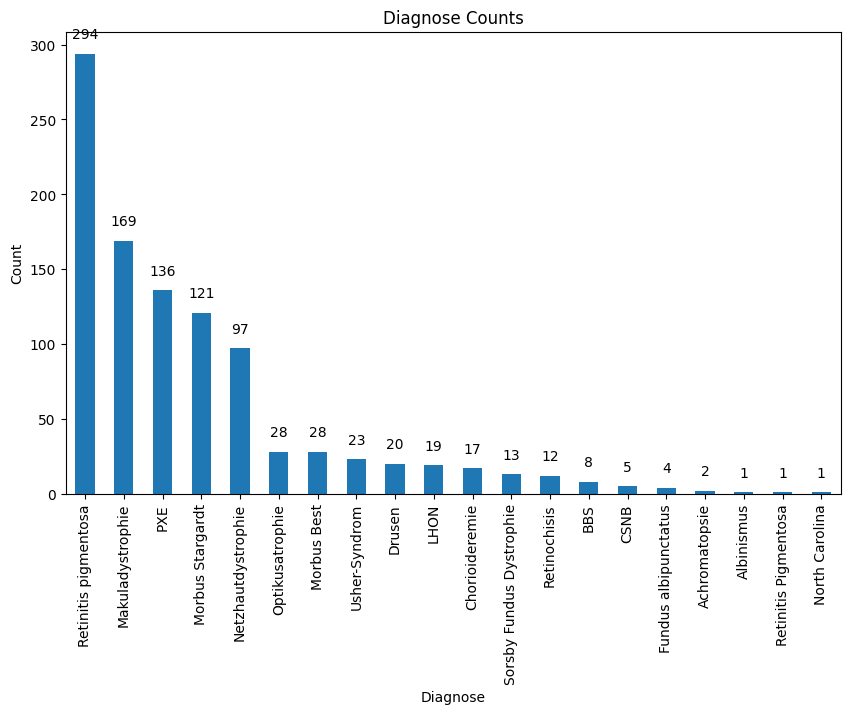

Diagnose
Retinitis pigmentosa        294
Makuladystrophie            169
PXE                         136
Morbus Stargardt            121
Netzhautdystrophie           97
Optikusatrophie              28
Morbus Best                  28
Usher-Syndrom                23
Drusen                       20
LHON                         19
Chorioideremie               17
Sorsby Fundus Dystrophie     13
Retinochisis                 12
BBS                           8
CSNB                          5
Fundus albipunctatus          4
Achromatopsie                 2
Albinismus                    1
Retinitis Pigmentosa          1
North Carolina                1
Name: count, dtype: int64


In [10]:
diagnosis_df['Diagnose'] = diagnosis_df.Diagnose.str.strip()
#count the Diagnosen
diagnosis_counts = diagnosis_df['Diagnose'].value_counts()
plt.figure(figsize=(10,6))
#create a bar plot which shows the number of each Diagnose
diagnosis_counts.plot(kind='bar')
plt.title('Diagnose Counts')
plt.xlabel('Diagnose')
plt.ylabel('Count')
plt.xticks(rotation=90)
for i, v in enumerate(diagnosis_counts):
    plt.text(i, v + 10, str(v), ha='center')
plt.show()

print(diagnosis_counts)

In [14]:
#filter to Retinitis pigmentosa, Morbus Stargardt, Morbus Best
diagnosis_df = diagnosis_df[diagnosis_df['Diagnose'].isin(['Retinitis pigmentosa', 'Morbus Stargardt', 'Morbus Best'])]
#count the Diagnosen
diagnosis_df['Diagnose'].value_counts()

Diagnose
Retinitis pigmentosa    294
Morbus Stargardt        121
Morbus Best              28
Name: count, dtype: int64

In [ ]:
#todos
'''
1. upload the two best trained models
2. read in data with label (create dataloader read from a table which has a file path and a label
create a function that creates this table from the dataset folder structure and the excel sheet with the labels)
3. filter the data to the three Diagnosen
2. execute on filtered data
3. evaluate the results
'''